In [76]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KernelDensity
import numpy as np
from numpy import array, linspace
from scipy.signal import argrelextrema
from numpy import array, linspace
from sklearn.neighbors.kde import KernelDensity
from matplotlib.pyplot import plot

In [4]:
#Setting the filepath and loading in a shapefile
file = "./files/countries.shp"
map_df = gpd.read_file(file)

#Loading the datasets & doing some data processing like column re-naming
df = pd.read_csv('./files/index.csv')
lang = pd.read_csv('./files/languages.csv', encoding = 'cp1252')
lang.columns = ['lang_id', 'code', 'language_name', 'perc_of_people_spoken', 'official']
countries = pd.read_csv('./files/countries.csv', encoding = 'cp1252')
countries.columns = ['country_name', 'iso_2', 'code']
df.columns = ['rank', 'code', 'country', 'ethnic_index', 'cultural_index']
regions = pd.read_csv('./files/regions.csv')

In [5]:
#Merging shp and file with the cultural index file to build a map based on the data
#As every language is in a separate row, aggregating the languages, % of people spoken and the language status
merged_index = map_df.set_index('ADM0_A3').join(df.set_index('code')).reset_index()
lang['aggregated'] = lang.iloc[:,2]+' (' + lang.iloc[:,3].astype(str) + '; ' +lang.iloc[:,4] + ')'
pvt = lang[['lang_id','code','aggregated']].pivot_table(index = 'code',columns = 'aggregated')
final_aggreg = pd.DataFrame(pvt.apply(lambda x: x.dropna().reset_index()['aggregated'].tolist(), axis = 1)).reset_index()
final_aggreg.columns = ['code', 'lang']
merged_lang = merged_index.set_index('ADM0_A3').join(final_aggreg.set_index('code')).reset_index()

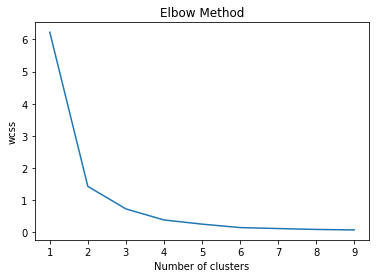

,cultural_index
0,
0,37
1,36
2,45
3,31


In [9]:
#To identify natural breaks, we will used K-means clustering algorithm. K-means is a simple unsupervised machine learning algorithm that groups a dataset into a user-specified number (k) of clusters. Dropping NAs as the K-means 'doesnt tolerate' missing values.
x = df[['cultural_index']].dropna()
#Although it's recommended to have between 5 and 10 categories, but we will use the elbow method to identify the number of classes
#The idea of the elbow method is to run k-means clustering on the dataset for a range of values of k (say, k from 1 to 10 in the examples above). The idea is to find the # of clusters where Within Cluster Sum of Squares is min. 
wcss = []
for i in range(1, 10):
    km = KMeans(n_clusters = i, random_state = 0)
    km.fit(x)
    wcss.append(km.inertia_)
plt.plot(range(1,10), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('wcss')
plt.show()
#Elbow at k=4 indicating 4 is the best number of clusters.
#Fitting kmeans to the dataset with k=4
km = KMeans(n_clusters = 4, random_state = 0)
y_means = km.fit_predict(x)
#Checking the # of observations in every class
pd.DataFrame(index = x.index, data = y_means).join(x).groupby(0).count()

Text(0.5,1,'Density plot')

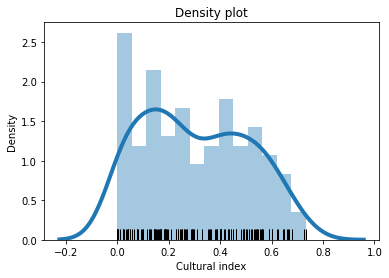

In [114]:
#Visualizing the data using a histogram and kernel density
sns.distplot(x, hist = True, kde = True, bins = 13, rug = True,
             kde_kws={'linewidth': 4},
             rug_kws={'color': 'black'})
plt.xlabel('Cultural index')
plt.ylabel('Density')
plt.title('Density plot')

In [105]:
X = np.array(x.iloc[:,0].tolist()).reshape(-1, 1)
#Finding the optimal bandwidth
bandwidths = np.linspace( 1.75, 149)
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': bandwidths})
grid.fit(x)
print(grid.best_params_)

{'bandwidth': -1.0}


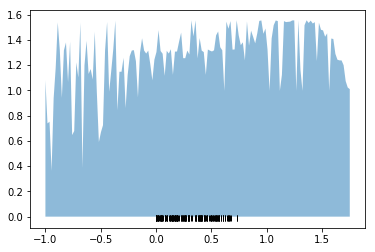

In [110]:
kde = KernelDensity(kernel = 'gaussian', bandwidth = 0.1).fit(X)
logprob = kde.score_samples(X)
plt.fill_between(bandwidths, np.exp(logprob), alpha=0.5)
plt.plot(X, np.full_like(X, -0.01), '|k', markeredgewidth=1)

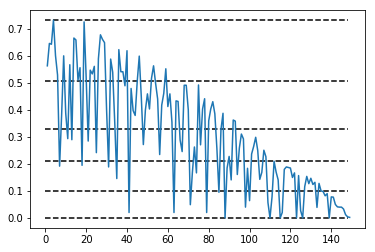

In [58]:
#Implementing Jenks Natural Breaks
def get_jenks_breaks(data_list, number_class):
    data_list.sort()
    mat1 = []
    for i in range(len(data_list) + 1):
        temp = []
        for j in range(number_class + 1):
            temp.append(0)
        mat1.append(temp)
    mat2 = []
    for i in range(len(data_list) + 1):
        temp = []
        for j in range(number_class + 1):
            temp.append(0)
        mat2.append(temp)
    for i in range(1, number_class + 1):
        mat1[1][i] = 1
        mat2[1][i] = 0
        for j in range(2, len(data_list) + 1):
            mat2[j][i] = float('inf')
    v = 0.0
    for l in range(2, len(data_list) + 1):
        s1 = 0.0
        s2 = 0.0
        w = 0.0
        for m in range(1, l + 1):
            i3 = l - m + 1
            val = float(data_list[i3 - 1])
            s2 += val * val
            s1 += val
            w += 1
            v = s2 - (s1 * s1) / w
            i4 = i3 - 1
            if i4 != 0:
                for j in range(2, number_class + 1):
                    if mat2[l][j] >= (v + mat2[i4][j - 1]):
                        mat1[l][j] = i3
                        mat2[l][j] = v + mat2[i4][j - 1]
        mat1[l][1] = 1
        mat2[l][1] = v
    k = len(data_list)
    kclass = []
    for i in range(number_class + 1):
        kclass.append(min(data_list))
    kclass[number_class] = float(data_list[len(data_list) - 1])
    count_num = number_class
    while count_num >= 2:  # print "rank = " + str(mat1[k][count_num])
        idx = int((mat1[k][count_num]) - 2)
        # print "val = " + str(data_list[idx])
        kclass[count_num - 1] = data_list[idx]
        k = int((mat1[k][count_num] - 1))
        count_num -= 1
    return kclass

breaks = get_jenks_breaks(X, 5)

for line in breaks:
    plt.plot([line for _ in range(len(x))], 'k--')
plt.plot(x)
plt.show()